<a href="https://colab.research.google.com/github/gonzaq94/NER-LLM-classification/blob/main/fine_tune_BERT_doc_level_and_NER_annots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import comet_ml
import comet_llm
import os
import gdown
from datasets import load_dataset, concatenate_datasets
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from openai import OpenAI
import seaborn as sns
import numpy as np
from torch.nn import CrossEntropyLoss, MSELoss


# Data preparation

In [10]:
from datasets import load_from_disk

loaded_train_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_train_augmented_1k_strat")
loaded_valid_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_valid_augmented_1k_strat")
loaded_test_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_test_augmented")

In [11]:
# log results and assets to Comet
os.environ["COMET_LOG_ASSETS"] = "True"
os.environ["COMET_WORKSPACE"] = "gonzaq94"
os.environ["COMET_PROJECT_NAME"] = "ner_classif-bert-doc_level_and_NER_annots-strat_data"

In [12]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

class SeqTokenDataset(Dataset):
    def __init__(self, texts, token_labels, sequence_labels, tokenizer, max_length):
        self.texts = texts
        self.token_labels = token_labels
        self.sequence_labels = sequence_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        token_labels = self.token_labels[idx]
        sequence_labels = self.sequence_labels[idx]

        tokens = []
        labels_per_token = []
        attention_masks = []

        # first add the CLS special token
        tokens.append(self.tokenizer.cls_token_id)
        labels_per_token.append(-100)
        attention_masks.append(0)

        # tokenize each word independantly
        for word, label in zip(text, token_labels):
          # Tokenize each word
          word_encoding = self.tokenizer(
              word,
              add_special_tokens=False,
              max_length=self.max_length,
              truncation=True,
              return_tensors="pt"
          )

          tokens.extend(word_encoding['input_ids'][0].tolist())
          attention_masks.extend(word_encoding['attention_mask'][0].tolist())
          labels_per_token.extend([label] * len(word_encoding['input_ids'][0]))

        # finally, add the SEP special token
        tokens.append(self.tokenizer.sep_token_id)
        labels_per_token.append(-100)
        attention_masks.append(0)

        # add padding
        padding_len = self.max_length - len(tokens)
        tokens += [0] * padding_len
        attention_masks += [0] * padding_len
        labels_per_token += [-100] * padding_len

        return {
            'input_ids': torch.tensor(tokens).flatten(),
            'attention_mask': torch.tensor(attention_masks).flatten(),
            'token_labels': torch.tensor(labels_per_token).flatten(),
            'sequence_labels': torch.tensor(sequence_labels).flatten()
        }

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
#loaded_train_dataset = loaded_train_dataset.shuffle().select(range(10))
#loaded_valid_dataset = loaded_valid_dataset.shuffle().select(range(10))

train_custom_dataset = SeqTokenDataset(
    texts=loaded_train_dataset['tokens'],
    token_labels=loaded_train_dataset['ner_tags'],
    sequence_labels=loaded_train_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

valid_custom_dataset = SeqTokenDataset(
    texts=loaded_valid_dataset['tokens'],
    token_labels=loaded_valid_dataset['ner_tags'],
    sequence_labels=loaded_valid_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

test_custom_dataset = SeqTokenDataset(
    texts=loaded_test_dataset['tokens'],
    token_labels=loaded_test_dataset['ner_tags'],
    sequence_labels=loaded_test_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

# Define Sequence and token classification model

In [29]:
from transformers import BertPreTrainedModel, BertModel, BertConfig
import torch.nn as nn

class CustomBertConfig(BertConfig):
    def __init__(self, num_token_labels = 10, num_sequence_labels = 2, seq_loss_weight = 1, **kwargs):
        super().__init__(**kwargs)
        self.num_token_labels = num_token_labels
        self.num_sequence_labels = num_sequence_labels
        self.seq_loss_weight = seq_loss_weight

class BertForSequenceAndTokenClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels_sequence = config.num_sequence_labels
        self.num_labels_token = config.num_token_labels
        self.seq_loss_weight = config.seq_loss_weight

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.token_classifier = nn.Linear(config.hidden_size, self.num_labels_token)
        self.sequence_classifier = nn.Linear(config.hidden_size, self.num_labels_sequence)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        token_labels=None,
        sequence_labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )

        # token classification
        token_representation = self.dropout(outputs.last_hidden_state)
        token_logits = self.token_classifier(token_representation)

        # sequence classification
        sequence_representation = self.dropout(outputs.pooler_output)
        sequence_logits = self.sequence_classifier(sequence_representation)

        outputs = (token_logits,) + (sequence_logits,) + outputs[2:]  # add hidden states and attention if they are here

        # token loss
        if token_labels is not None or sequence_labels is not None:
          if token_labels is not None:
              loss_fct = CrossEntropyLoss()

              if attention_mask is not None:
                  active_token_loss = attention_mask.view(-1) == 1
                  active_token_logits = token_logits.view(-1, self.num_labels_token)
                  active_labels_token = torch.where(
                      active_token_loss, token_labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(token_labels)
                  )
                  token_loss = loss_fct(active_token_logits, active_labels_token)
              else:
                  token_loss = loss_fct(token_logits.view(-1, self.num_labels_token), token_labels.view(-1))
          else:
            token_loss = 0.0

          # sequence loss
          if sequence_labels is not None:
            if self.num_labels_sequence == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                sequence_loss = loss_fct(sequence_logits.view(-1), sequence_labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                sequence_loss = loss_fct(sequence_logits.view(-1, self.num_labels_sequence), sequence_labels.view(-1))
          else:
            sequence_loss = 0.0

          total_loss = (1 - self.seq_loss_weight) * token_loss + self.seq_loss_weight * sequence_loss

          outputs = (total_loss,) + outputs

        return outputs  # (loss), token_logits, sequence_logits, (hidden_states), (attentions)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, num_token_labels, num_sequence_labels, seq_loss_weight=1, *args, **kwargs):

        # load config
        config = CustomBertConfig.from_pretrained(pretrained_model_name_or_path, *args, **kwargs)
        config.num_token_labels = num_token_labels
        config.num_sequence_labels = num_sequence_labels
        config.seq_loss_weight = seq_loss_weight

        # create model instance
        model = cls(config)

        # load BERT pre-trained weights
        model.bert = BertModel.from_pretrained(pretrained_model_name_or_path)

        return model



In [54]:
def compute_metrics(p):

    predictions, labels = p
    ner_predictions, doc_predictions = predictions
    ner_labels, doc_labels = labels

    # NER metrics
    ner_predictions = ner_predictions.argmax(-1)  # Get the predicted class indices
    true_ner_predictions = [p for (p, l) in zip(ner_predictions.flatten(), ner_labels.flatten()) if l != -100]
    true_ner_labels = [l for l in ner_labels.flatten() if l != -100]

    ner_precision, ner_recall, ner_f1, _ = precision_recall_fscore_support(true_ner_labels, true_ner_predictions, average='weighted', zero_division=1 )
    ner_acc = accuracy_score(true_ner_labels, true_ner_predictions)

    # doc-level metrics
    doc_predictions = doc_predictions.argmax(-1)  # Get the predicted class indices
    doc_precision, doc_recall, doc_f1, _ = precision_recall_fscore_support(doc_labels, doc_predictions, average='weighted', zero_division=1 )
    doc_acc = accuracy_score(doc_labels, doc_predictions)

    return {
        'ner_accuracy': ner_acc,
        'ner_f1': ner_f1,
        'ner_precision': ner_precision,
        'ner_recall': ner_recall,
        'doc_accuracy': doc_acc,
        'doc_f1': doc_f1,
        'doc_precision': doc_precision,
        'doc_recall': doc_recall,
        'f1': (doc_f1 + ner_f1) / 2,
    }

In [55]:
class_freqs = torch.tensor(np.histogram(loaded_train_dataset['doc_labels'], bins=5)[0]).to("cpu")
class_weights = 1.0 / class_freqs
class_weights = class_weights / class_weights.sum()
print(class_weights, class_freqs)

tensor([0., 0., nan, 0., 0.]) tensor([1, 4, 0, 2, 3])


In [56]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# weighted loss
class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
      labels = inputs.get("labels")
      outputs = model(**inputs)
      logits = outputs.get("logits")

      loss_fct = CrossEntropyLoss(weight=class_weights)
      loss = loss_fct(logits.view(-1, len(class_weights)), labels.view(-1))

      return (loss, outputs) if return_outputs else loss


# weighted data loader
sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(class_weights), replacement=True)

def torch_weighted_data_collator(features):

    # Sample features with weights according to their label
    labels = [f["label"] for f in features]
    weights = [class_weights[label] for label in labels]
    total_weight = sum(weights)
    probabilities = [weight / total_weight for weight in weights]

    # Sample with probabilities
    features = random.choices(features, weights=probabilities, k=len(features))

    batch = {}

    # Convert features to tensors
    for k in features[0].keys():
        if k == 'label':
            newk = 'labels'
        else:
            newk = k
        if isinstance(features[0][k], torch.Tensor):
            batch[newk] = torch.stack([f[k] for f in features])  # Use stack for tensors
        else:
            batch[newk] = torch.tensor([f[k] for f in features])  # Convert to tensor

    return batch

def torch_default_data_collator(features):

    first = features[0]
    batch = {}

    # Special handling for labels.
    # Ensure that tensor is created with the correct type
    # (it should be automatically the case, but let's make sure of it.)
    if "label" in first and first["label"] is not None:
        label = first["label"].item() if isinstance(first["label"], torch.Tensor) else first["label"]
        dtype = torch.long if isinstance(label, int) else torch.float
        batch["labels"] = torch.tensor([f["label"] for f in features], dtype=dtype)
    elif "label_ids" in first and first["label_ids"] is not None:
        if isinstance(first["label_ids"], torch.Tensor):
            batch["labels"] = torch.stack([f["label_ids"] for f in features])
        else:
            dtype = torch.long if isinstance(first["label_ids"][0], int) else torch.float
            batch["labels"] = torch.tensor([f["label_ids"] for f in features], dtype=dtype)

    # Handling of all other possible keys.
    # Again, we will use the first element to figure out which key/values are not None for this model.
    for k, v in first.items():
        if k not in ("label", "label_ids") and v is not None and not isinstance(v, str):
            if isinstance(v, torch.Tensor):
                batch[k] = torch.stack([f[k] for f in features])
            elif isinstance(v, np.ndarray):
                batch[k] = torch.from_numpy(np.stack([f[k] for f in features]))
            else:
                batch[k] = torch.tensor([f[k] for f in features])

    return batch

In [57]:
doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}
ner_label_dct = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


model_name = 'bert-base-uncased'
model = BertForSequenceAndTokenClassification.from_pretrained(model_name,
                                                           num_sequence_labels=len(doc_label_dct),
                                                           num_token_labels=len(ner_label_dct),
                                                           seq_loss_weight=1,
                                                           attention_probs_dropout_prob=0.0,
                                                           hidden_dropout_prob=0.0)

In [58]:
from transformers.integrations import CometCallback

BATCH_SIZE = 8

experiment = comet_ml.Experiment(api_key=os.getenv("COMET_API_KEY"), project_name=os.getenv("COMET_PROJECT_NAME"), workspace=os.getenv("COMET_WORKSPACE"))

# Define a custom callback to ensure experiment.end() is called
class CustomCometCallback(CometCallback):

  def __init__(self, experiment):
      super().__init__()
      self._experiment = experiment

# define comet experiment
experiment = comet_ml.Experiment(
  api_key=os.getenv("COMET_API_KEY"),
  project_name=os.getenv("COMET_PROJECT_NAME"),
  workspace=os.getenv("COMET_WORKSPACE"))

experiment.set_name("test")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=63,
    learning_rate=2e-5,
    #lr_scheduler_type="cosine",
    weight_decay=0.01,
    logging_dir=None,
    dataloader_drop_last=False,
    fp16=True, # mixed precision
    report_to=["comet_ml"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_custom_dataset,
    eval_dataset=valid_custom_dataset,
    callbacks=[CustomCometCallback(experiment=experiment)],
    compute_metrics=compute_metrics,
    #compute_loss_func=compute_loss,
    #data_collator=torch_weighted_data_collator
)


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : test
COMET INFO:     url                   : https://www.comet.com/gonzaq94/ner-classif-bert-doc-level-and-ner-annots-strat-data/5eba25e58ac54279b604331d27cc30a6
COMET INFO:   Metrics:
COMET INFO:     epoch                   : 1.0
COMET INFO:     eval_doc_accuracy       : 0.3
COMET INFO:     eval_doc_f1             : 0.13846153846153847
COMET INFO:     eval_doc_precision      : 0.79
COMET INFO:     eval_doc_recall         : 0.3
COMET INFO:     eval_loss               : 1.5565160512924194
COMET INFO:     eval_ner_accuracy       : 0.032894736842105

In [59]:
trainer.train()

COMET INFO: An experiment with the same configuration options is already running and will be reused.
COMET INFO: An experiment with the same configuration options is already running and will be reused.


Epoch,Training Loss,Validation Loss,Ner Accuracy,Ner F1,Ner Precision,Ner Recall,Doc Accuracy,Doc F1,Doc Precision,Doc Recall,F1
1,1.759400,1.556516,0.032895,0.028039,0.832885,0.032895,0.300000,0.138462,0.790000,0.300000,0.083250
2,1.765700,1.555426,0.032895,0.028039,0.832885,0.032895,0.300000,0.138462,0.790000,0.300000,0.083250
3,1.470700,1.554051,0.032895,0.027836,0.832676,0.032895,0.300000,0.138462,0.790000,0.300000,0.083149


KeyboardInterrupt: 

## Log and register model in Comet

In [ ]:
experiment.log_model("ner_classif-bert-doc_level_and_NER_annots-strat_data", trainer.state.best_model_checkpoint)
experiment.register_model("ner_classif-bert-doc_level_and_NER_annots-strat_data")

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : frightened_apricot_5344
COMET INFO:     url                   : https://www.comet.com/gonzaq94/ner-classif-bert-doc-level-annots-strat-data/b5163229a9f4498bb5250bfe8e264c7e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [31]                   : (1.0, 15.0)
COMET INFO:     eval_accuracy [15]           : (0.24660194174757283, 0.8796116504854369)
COMET INFO:     eval_f1 [15]                 : (0.3008875445810343, 0.8839729131071746)
COMET INFO:     eval_loss [15]               : (0.3039099872112274, 1.524991750717163)
COMET INFO:     eval_precision [15]          : (0.6693201569376076, 0.8991127672593024)
COMET INFO:     eval_recall [15]

## Evaluate best model

In [ ]:
from comet_ml import API

api = API(api_key=os.getenv("COMET_API_KEY"))

# model name
model_name = "BERT-base-doc_classif-1k-stratified-wloss_wsampling"

#get the Model object
model = api.get_model(workspace=os.getenv("COMET_WORKSPACE"), model_name=model_name)

# Download a Registry Model:
model.download("1.0.0", "./deploy", expand=True)

COMET INFO: Remote Model 'gonzaq94/BERT-base-doc_classif-1k-stratified-wloss_wsampling:1.0.0' download has been started asynchronously.
COMET INFO: Still downloading 14 file(s), remaining 2.45 GB/2.45 GB
COMET WARNING: File './deploy/checkpoint-336/training_args.bin' has been overwritten by asset '1c35cbc477b844b5998f8fd742e9820a' of remote model
COMET WARNING: File './deploy/checkpoint-336/scheduler.pt' has been overwritten by asset '4e36675ca40b48dbb2d1cb5b0182695e' of remote model
COMET WARNING: File './deploy/checkpoint-336/trainer_state.json' has been overwritten by asset '3acd262a0cae466482c69fa6c3a32ae0' of remote model
COMET WARNING: File './deploy/checkpoint-336/scheduler.pt' has been overwritten by asset '532308c9cdf4429088bfadfbf7b62421' of remote model
COMET WARNING: File './deploy/checkpoint-336/config.json' has been overwritten by asset '5edf49a92c5241b7b411f1b5eafd967a' of remote model
COMET WARNING: File './deploy/checkpoint-336/optimizer.pt' has been overwritten by ass

In [ ]:
def plot_confusion_matrix(cm, class_names):

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def compute_metrics_eval(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions, normalize='true')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix
    }


class Evaluator:
    def __init__(self, model, tokenizer, compute_metrics):
        self.model = model
        self.tokenizer = tokenizer
        self.compute_metrics = compute_metrics

    def evaluate(self, eval_dataset, batch_size=16):
        trainer = Trainer(
            model=self.model,
            args=training_args,
            compute_metrics=self.compute_metrics,
            eval_dataset=eval_dataset,
        )
        return trainer.evaluate()

In [ ]:
doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}
model = AutoModelForSequenceClassification.from_pretrained("./deploy/checkpoint-336", num_labels=len(doc_label_dct))


In [ ]:
evaluator = Evaluator(model, tokenizer, compute_metrics_eval)
eval_results = evaluator.evaluate(test_custom_dataset)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


COMET INFO: An experiment with the same configuration options is already running and will be reused.
COMET WARNING: Cannot safely convert array([[9.16317992e-01, 1.25523013e-02, 2.51046025e-02, 0.00000000e+00,
        4.60251046e-02],
       [1.56372166e-03, 8.98358092e-01, 7.81860829e-04, 0.00000000e+00,
        9.92963253e-02],
       [5.48245614e-02, 4.38596491e-03, 8.55263158e-01, 4.38596491e-03,
        8.11403509e-02],
       [0.00000000e+00, 0.00000000e+00, 2.14285714e-01, 5.71428571e-01,
        2.14285714e-01],
       [7.44027304e-02, 1.21501706e-01, 4.36860068e-02, 1.36518771e-03,
        7.59044369e-01]]) object to a scalar value, using its string representation for logging. Resulting string might be invalid


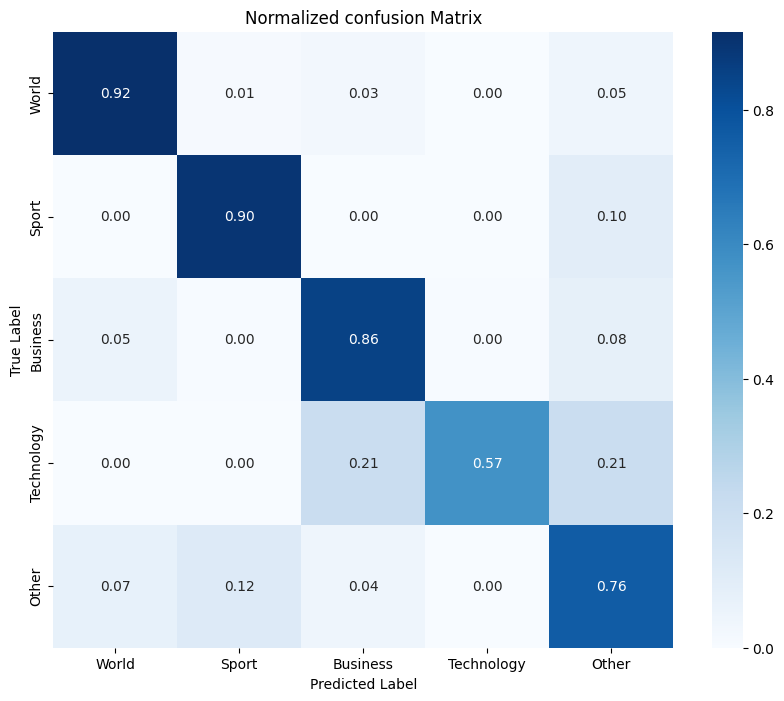

In [ ]:
class_names = [k for k, v in doc_label_dct.items()]
plot_confusion_matrix(eval_results['eval_confusion_matrix'], class_names)

In [ ]:
for key, value in eval_results.items():
  if key != 'eval_confusion_matrix':
    print(f"{key}: {value}")

eval_loss: 0.5044994354248047
eval_model_preparation_time: 0.0035
eval_accuracy: 0.8334781349551115
eval_f1: 0.8339902590250613
eval_precision: 0.8416399874694014
eval_recall: 0.8334781349551115
eval_runtime: 12.0451
eval_samples_per_second: 286.674
eval_steps_per_second: 17.933
